In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [83]:
# Installing Dependencies
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly packages
import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Crpyto Data from Yahoo Finance
import yfinance as yf

# Modelling
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [3]:
# Getting BTC-USD data
ticker = 'BTC-USD'
start_date = '2019-01-01'
end_date = '2024-09-10'

# Retrieving
btc = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
btc.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

                Volume  
Date                    
2019-01-01  4324200990  
2019-01-02  5244856836  
2019-01-03  4530215219  
2019-01-04  4847965467  
2019-01-05  5137609824

In [5]:
btc.tail()

Open          High           Low         Close  \
Date                                                                 
2024-09-05  57971.703125  58300.582031  55712.453125  56160.488281   
2024-09-06  56160.191406  56976.109375  52598.699219  53948.753906   
2024-09-07  53949.085938  54838.144531  53740.070312  54139.687500   
2024-09-08  54147.933594  55300.859375  53653.757812  54841.566406   
2024-09-09  54851.886719  58041.125000  54598.433594  57019.535156   

               Adj Close       Volume  
Date                                   
2024-09-05  56160.488281  31030280656  
2024-09-06  53948.753906  49361693566  
2024-09-07  54139.687500  19061486526  
2024-09-08  54841.566406  18268287531  
2024-09-09  57019.535156  34618096173

In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2079 entries, 2019-01-01 to 2024-09-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2079 non-null   float64
 1   High       2079 non-null   float64
 2   Low        2079 non-null   float64
 3   Close      2079 non-null   float64
 4   Adj Close  2079 non-null   float64
 5   Volume     2079 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 113.7 KB


# Visualisation & EDA

<Axes: xlabel='Date'>

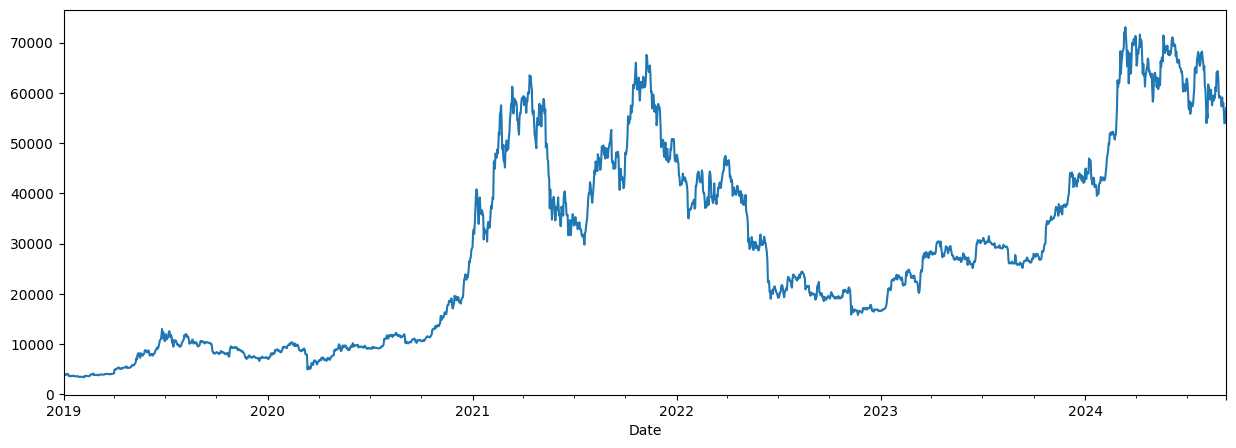

In [7]:
# Plotting the close price over the period
btc['Close'].plot(figsize = (15,5))

<Axes: xlabel='Close', ylabel='Density'>

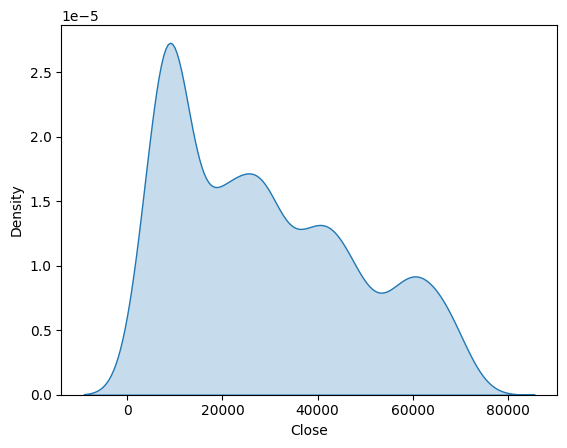

In [8]:
sns.kdeplot(btc['Close'], shade = True)

Closing price of Bitcoin has predominantly been in the ~13000 area. Close price greatly declined from mid 2022 to mid 2023 after the pandemic.

<Axes: xlabel='Date'>

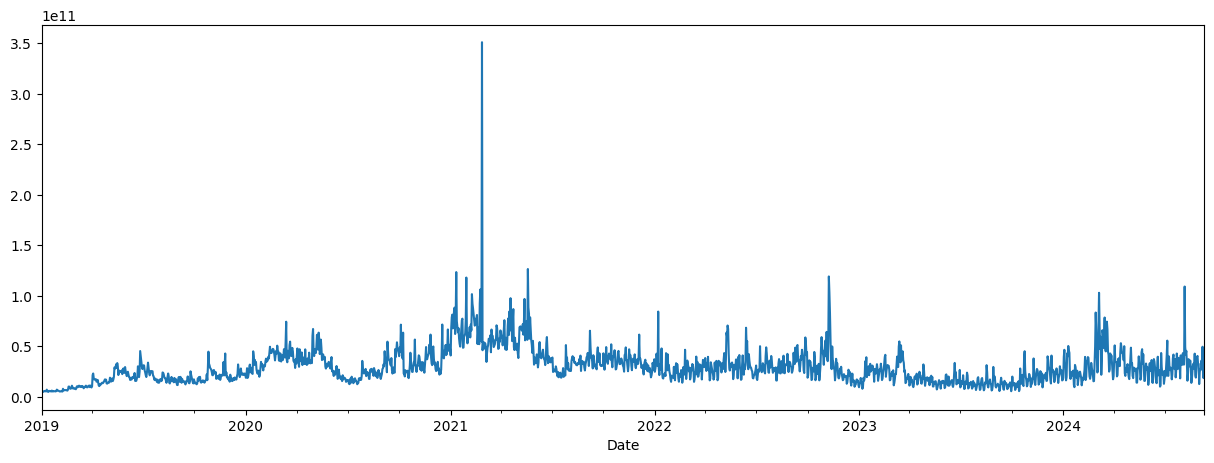

In [9]:
# Plotting the volume price over the period
btc['Volume'].plot(figsize = (15,5))

Huge spike in volume when BTC broke 60k for the first time

In [10]:
# Creating a returns column - change between the opening price and adjusted close over the course of a day
btc['Return'] = (btc['Adj Close'] - btc['Open'])/btc['Open']

btc.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

                Volume    Return  
Date                              
2019-01-01  4324200990  0.025838  
2019-01-02  5244856836  0.024471  
2019-01-03  4530215219 -0.023990  
2019-01-04  4847965467  0.006701  
2019-01-05  5137609824 -0.001760

In [11]:
# Making copy of data so as we can reset date as index for our visualisations
btc_data = btc.copy()
btc_data = btc_data.reset_index()

In [12]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2079 non-null   datetime64[ns]
 1   Open       2079 non-null   float64       
 2   High       2079 non-null   float64       
 3   Low        2079 non-null   float64       
 4   Close      2079 non-null   float64       
 5   Adj Close  2079 non-null   float64       
 6   Volume     2079 non-null   int64         
 7   Return     2079 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 130.1 KB


In [13]:
# Creating plotly function for range slider and selectors
def plotly_slider(y_variable):
    fig = px.line(btc_data, x = 'Date', y = y_variable, title = f"BTC {y_variable} - Slider & Selector")
    fig.update_xaxes(rangeslider_visible = True, rangeselector = dict(buttons = list([
        dict(count = 1, label = "1M", step = "month", stepmode = "backward"),
        dict(count = 6, label = "6M", step = "month", stepmode = "backward"),
        dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
        dict(count = 1, label = "1Y", step = "year", stepmode = "backward"),
        dict(step = "all")
    ])))
    return fig

In [14]:
plotly_slider('Close')

In [15]:
plotly_slider('Return')

### Candlestick plots

In [16]:
fig = go.Figure(data=[go.Candlestick(x = btc_data['Date'], open = btc_data['Open'], high = btc_data['High'], low = btc_data['Low'], close = btc_data['Close'])])
fig.show()

# Shifting & Lags
- To compare the time series with a past of itself, we can shift the index by a desired number of periods
- Lagged features are features which as created by shifting the original data by one or more time periods
- These features can help capture patterns, trends, and seasonality in the data
- Can also be used in autoregressive models
- Autoregressive models are models that use past values of the target variable to predict future values

In [17]:
btc_data.head()

Date         Open         High          Low        Close    Adj Close  \
0 2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
1 2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2 2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
3 2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
4 2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

       Volume    Return  
0  4324200990  0.025838  
1  5244856836  0.024471  
2  4530215219 -0.023990  
3  4847965467  0.006701  
4  5137609824 -0.001760

In [18]:
btc_data = btc_data.set_index('Date')

In [19]:
fig = go.Figure()
# Ensuring Close_M contains daily closing prices for bitcoin
btc_data['Close_M'] = btc_data["Close"].asfreq('d')
# Lag_Close_M is the lagged version of close prices - it contains the closing price from 10 days earlier
btc_data['Lag_Close_M'] = btc_data['Close'].asfreq('d').shift(10)

# Creating two trace lines to compare the closing price vs the lagged closing price
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data.Close_M, name='Close_M'))
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data.Lag_Close_M, name='Lag_Close_M'))
fig.show()

In [20]:
# Adding lagged features for volume
fig = go.Figure()
# Ensuring Close_M contains daily closing prices for bitcoin
btc_data['Volume_M'] = btc_data["Volume"].asfreq('d')
# Lag_Close_M is the lagged version of close prices - it contains the closing price from 10 days earlier
btc_data['Lag_Volume_M'] = btc_data['Volume'].asfreq('d').shift(10)

# Creating two trace lines to compare the closing price vs the lagged closing price
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data.Volume_M, name='Volume_M'))
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data.Lag_Volume_M, name='Lag_Volume_M'))
fig.show()

# Technical Indicators

### Simple Moving Average
- Calculates the average prices over a given interval of time
- Used to determine the trend of the stock
- SMA 15 = 15 day time interval - in this case it would be a slow SMA
- SMA 5 = 5 day time interval - fast SMA
- SMA is commonly used, however it can be biased due to giving equal weight to each value in the past

In [21]:
btc_data['SMA_5'] = btc_data['Close'].rolling(5).mean().shift()
btc_data['SMA_15'] = btc_data['Close'].rolling(15).mean().shift()

# Plot the SMA's against the Close price
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['SMA_5'], name = 'SMA_5'))
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['SMA_15'], name = 'SMA_15'))
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['Close'], name = 'Close'))

### Exponential Moving Average
- Similar to SMA, however EMA adds greater weight to more recent pricing data

In [22]:
btc_data['EMA_5'] = btc_data['Close'].ewm(5).mean().shift()
btc_data['EMA_15'] = btc_data['Close'].ewm(15).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['EMA_5'], name = 'EMA_5'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['EMA_15'], name = 'EMA_15'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['Close'], name = 'Close', opacity = 0.3))
fig.show()

In [23]:
# Comparing SMA_5 vs EMA_5
fig = go.Figure()
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['SMA_5'], name = 'SMA_5'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['EMA_5'], name = 'EMA_5'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['Close'], name = 'Close', opacity = 0.3))
fig.show()

SMA over the long term trend appears to capture Bitcoin's close price trend quite well. Lets see if this is the case if we limit the data for the last year.

In [24]:
fig = go.Figure(layout_xaxis_range=['2023-09-01','2024-09-01'])
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['SMA_5'], name = 'SMA_5'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['EMA_5'], name = 'EMA_5'))
fig.add_trace(go.Scatter(x = btc_data.index, y = btc_data['Close'], name = 'Close', opacity = 0.3))
fig.show()

SMA again is closer to the close price of Bitcoin over the last year and thus a better performer than EMA.

### Relative Strength Index
- RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate whether a stock/cryptocurrency is being overbought or oversold
- RSI > 70 = overbought
- RSI < 30 = oversold
- Basic Formula:
        RSI = 100 - [100 / (1 + (Average of upward price change / average of downward price change))]


In [25]:
# Creating RSI Function

# 'n' is the number of periods which at default is 14
def RSI(df, n = 14):
    close = df['Close']
    # calculating the difference between close price in consecutive days
    delta = close.diff()
    # removing the first value (NaN) as there's no previous day to calculate the difference for the first row
    delta = delta[1:]
    # creating copies of the delta, one to store upward trends and the other to store downward trends
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    # replacing any negative values with 0, i.e. only keeping the positive price changes
    pricesUp[pricesUp<0] = 0
    # replacing any positive values with 0, i.e. only keeping the negative price changes
    pricesDown[pricesDown>0] = 0
    # calculates the rolling mean of upward trend over the last 'n' periods. Smooths the price gains over time
    rollUp = pricesUp.rolling(n).mean()
    # calculates the rolling mean of downward price changes. Using 'abs()' to convert them to positive numbers before calculating the mean
    rollDown = pricesDown.abs().rolling(n).mean()
    # calculating relative strength - ratio of average gains vs losses
    rs = rollUp/rollDown
    rsi = 100.0 - (100 / (1.0 + rs))
    return rsi

btc_data['RSI'] = RSI(btc_data).fillna(0)

fig = go.Figure(go.Scatter(x = btc_data.index, y = btc_data['RSI'], name = 'RSI'))

# Add a dotted line at the 70 level (overbought)
fig.add_shape(
    type="line",
    x0=btc_data.index.min(), x1=btc_data.index.max(),
    y0=70, y1=70,
    line=dict(color="red", width=2, dash="dot"),
    name='Overbought (70)'
)

# Add a dotted line at the 30 level (oversold)
fig.add_shape(
    type="line",
    x0=btc_data.index.min(), x1=btc_data.index.max(),
    y0=30, y1=30,
    line=dict(color="green", width=2, dash="dot"),
    name='Oversold (30)'
)

fig.show()

### Price Momentum

- Price momentum is a measure of how fast the price of a financial instrument is moving in a certain direction over time
- It's the difference between the current price and the price from a previous time period
- If current price > price from 'n' periods ago, momentum is positive, indicatin upward trend and viceversa
- Helps gauge the strength of price movements and identify trends

In [31]:
#Calculation of price momentum
def mom(df, n):     
    # n = number of periods in days
    return pd.Series(df.diff(n), name='Momentum_' + str(n))

btc_data['MOM5'] = mom(btc_data['Close'], 5)
btc_data['MOM15'] = mom(btc_data['Close'], 15)

In [35]:
fig = go.Figure(layout_xaxis_range=['2023-09-01','2024-09-01'])

fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['Close'], 
                         mode='lines', name='Close Price'))

# Add a trace for Momentum_5 (5-day momentum)
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['MOM5'], 
                         mode='lines', name='Momentum (5 periods)', 
                         yaxis="y2", line=dict(dash='dash', color='red')))

# Customize layout to show two y-axes for better comparison
fig.update_layout(
    title="Bitcoin Close Price and Momentum (5)",
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis2=dict(title="Momentum", overlaying="y", side="right"),
    legend_title="Indicators",
    height=600
)

# Show the plot
fig.show()


In [36]:
fig = go.Figure(layout_xaxis_range=['2023-09-01','2024-09-01'])

fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['Close'], 
                         mode='lines', name='Close Price'))

# Add a trace for Momentum_5 (5-day momentum)
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['MOM15'], 
                         mode='lines', name='Momentum (15 periods)', 
                         yaxis="y2", line=dict(dash='dash', color='red')))

# Customize layout to show two y-axes for better comparison
fig.update_layout(
    title="Bitcoin Close Price and Momentum (15)",
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis2=dict(title="Momentum", overlaying="y", side="right"),
    legend_title="Indicators",
    height=600
)

# Show the plot
fig.show()


It appears the momentum feature with 15 periods better generalises Bitcoin's trend over the last year

### Rates of Change
- Another momentum indicator that measures the **percentage** change in price between the current price and the price from 'n' periods ago
- Indicates how quickly a stock or financial instrument's price is changing over time
- Typically used to identify overbought/oversold conditions and assess the speed of price movements

In [37]:
# rate of change
def roc(df, n):  
    M = df.diff(n - 1) 
    N = df.shift(n - 1)  
    return pd.Series(((M / N) * 100), name = 'ROC_' + str(n))

btc_data['ROC5'] = roc(btc_data['Close'], 5)
btc_data['ROC15'] = roc(btc_data['Close'], 15)

In [38]:
fig = go.Figure(layout_xaxis_range=['2023-09-01','2024-09-01'])

fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['Close'], 
                         mode='lines', name='Close Price'))

# Add a trace for the Rate of Change (ROC_5) using a dashed line
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['ROC5'], 
                         mode='lines', name='ROC (5 periods)', 
                         yaxis="y2", line=dict(dash='dash', color='red')))

fig.update_layout(
    title="Bitcoin Close Price and Rate of Change (ROC5)",
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis2=dict(title="Rate of Change (ROC)", overlaying="y", side="right"),
    legend_title="Indicators",
    height=600
)

# Show the plot
fig.show()


In [40]:
fig = go.Figure(layout_xaxis_range=['2023-09-01','2024-09-01'])

fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['Close'], 
                         mode='lines', name='Close Price'))

fig.add_trace(go.Scatter(x=btc_data.index, y=btc_data['ROC15'], 
                         mode='lines', name='ROC (15 periods)', 
                         yaxis="y2", line=dict(dash='dash', color='green')))

fig.update_layout(
    title="Bitcoin Close Price and Rate of Change (ROC15)",
    xaxis_title="Date",
    yaxis_title="Close Price",
    yaxis2=dict(title="Rate of Change (ROC)", overlaying="y", side="right"),
    legend_title="Indicators",
    height=600
)

# Show the plot
fig.show()

# Time Series Decomposition

- We can decompose a time series into trend, seasonal and remainder components
    - Trend - long term movement
    - Seasonality - regular patters that repeat at specific intervals
    - Remainder (residual) - unpredictable part of price movement which is random noise or other factors not captured by trend/seasonal patterns
- A series can be decomposed as an additive or multiplicative combination of the base level, trend, seasonal index, and the residual
    - Additive Decomposition- in an additive model the total stock/crypto price is the sum of the components:
        - **Price = Base Level + Trend + Seasonality + Residual**
        - Works well if seasonal effect is constant over time (e.g. the price always increases by a fixed amount in June every year), **linearly**
    - Multiplicative Decomposition - components are multiplied:
        - **Price = Base Level x Trend x Seasonality x Residual**
        - Here, seasonal and residual effects change in **proportion** to the stock price. Works better when the seasonality and noise grow with the price
        - E.g., price rises and seasonal swings become larger

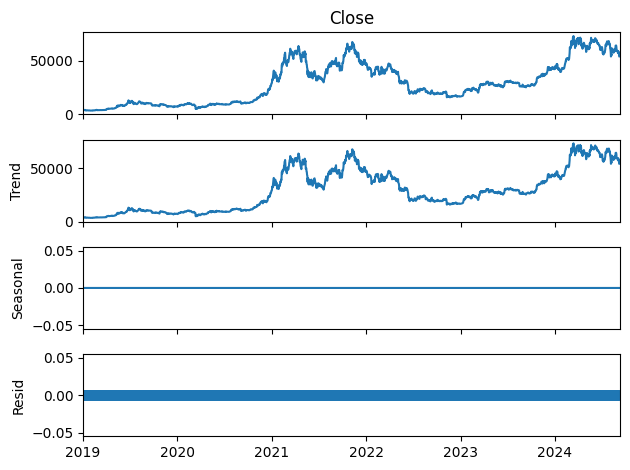

In [26]:
series = btc_data['Close']
result = seasonal_decompose(series, model = "additive", period = 1) # this period means daily
figure = result.plot()

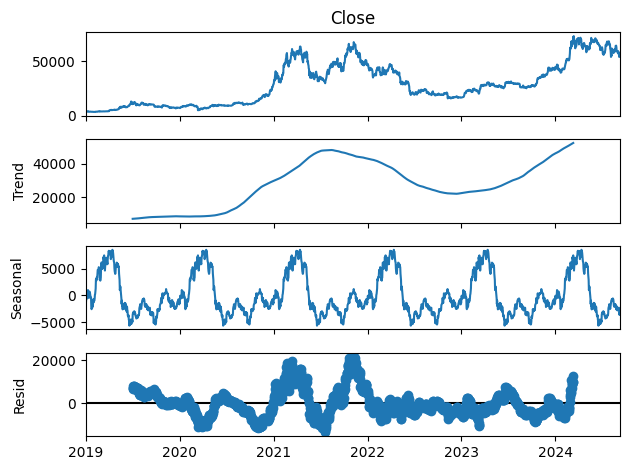

In [27]:
series = btc_data['Close']
result = seasonal_decompose(series, model = "additive", period = 365) # this period means yearly
figure = result.plot()

- The trend for the most part is upward with a decline from 2022 to 2023
- Definitely uniform seasonality present in the data
- Non-uniform noise present in the data

In [29]:
btc_data.tail()

Open          High           Low         Close  \
Date                                                                 
2024-09-05  57971.703125  58300.582031  55712.453125  56160.488281   
2024-09-06  56160.191406  56976.109375  52598.699219  53948.753906   
2024-09-07  53949.085938  54838.144531  53740.070312  54139.687500   
2024-09-08  54147.933594  55300.859375  53653.757812  54841.566406   
2024-09-09  54851.886719  58041.125000  54598.433594  57019.535156   

               Adj Close       Volume    Return       Close_M   Lag_Close_M  \
Date                                                                          
2024-09-05  56160.488281  31030280656 -0.031243  56160.488281  62880.660156   
2024-09-06  53948.753906  49361693566 -0.039377  53948.753906  59504.132812   
2024-09-07  54139.687500  19061486526  0.003533  54139.687500  59027.625000   
2024-09-08  54841.566406  18268287531  0.012810  54841.566406  59388.179688   
2024-09-09  57019.535156  34618096173  0.039518  57019.535156  59119.476562   

               Volume_M  Lag_Volume_M         SMA_5        SMA_15  \
Date                                                                
2024-09-05  31030280656  2.768204e+10  58162.085938  60326.300000   
2024-09-06  49361693566  3.910388e+10  57600.203906  59991.986458   
2024-09-07  19061486526  4.028956e+10  56924.857031  59563.109115   
2024-09-08  18268287531  3.222499e+10  55930.298438  58899.464583   
2024-09-09  34618096173  3.229276e+10  55412.407031  58276.969531   

                   EMA_5        EMA_15        RSI  
Date                                               
2024-09-05  59056.281994  60129.609023  37.939341  
2024-09-06  58573.649708  59881.538977  18.295196  
2024-09-07  57802.833741  59510.739910  18.834421  
2024-09-08  57192.309368  59175.049135  21.501944  
2024-09-09  56800.518874  58904.206464  33.137153

# Modelling
- When modelling we will use the hold-out validation method whereby we will train the model from 2019 to 2023, and validate using 2024
- https://www.kaggle.com/code/akashmathur2212/bitcoin-price-prediction-arima-xgboost-lstm-fbprop#Model-Building

In [64]:
btc = btc_data.reset_index()
btc.head()


Date         Open         High          Low        Close    Adj Close  \
0 2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
1 2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2 2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
3 2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
4 2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

       Volume    Return      Close_M  Lag_Close_M  ...  Lag_Volume_M  SMA_5  \
0  4324200990  0.025838  3843.520020          NaN  ...           NaN    NaN   
1  5244856836  0.024471  3943.409424          NaN  ...           NaN    NaN   
2  4530215219 -0.023990  3836.741211          NaN  ...           NaN    NaN   
3  4847965467  0.006701  3857.717529          NaN  ...           NaN    NaN   
4  5137609824 -0.001760  3845.194580          NaN  ...           NaN    NaN   

   SMA_15        EMA_5       EMA_15  RSI  MOM5  MOM15      ROC5  ROC15  
0     NaN          NaN          NaN  NaN   NaN    NaN       NaN    NaN  
1     NaN  3843.520020  3843.520020  0.0   NaN    NaN       NaN    NaN  
2     NaN  3898.005149  3895.075841  0.0   NaN    NaN       NaN    NaN  
3     NaN  3873.768866  3874.363407  0.0   NaN    NaN       NaN    NaN  
4     NaN  3868.601819  3869.790842  0.0   NaN    NaN  0.043568    NaN  

[5 rows x 21 columns]

In [65]:
btc.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return',
       'Close_M', 'Lag_Close_M', 'Volume_M', 'Lag_Volume_M', 'SMA_5', 'SMA_15',
       'EMA_5', 'EMA_15', 'RSI', 'MOM5', 'MOM15', 'ROC5', 'ROC15'],
      dtype='object')

In [66]:
btc["Month"] = btc.Date.dt.month
btc["Week"] = btc.Date.dt.isocalendar().week 
btc["Day"] = btc.Date.dt.day
btc["Day_of_Week"] = btc.Date.dt.weekday
btc.head()

Date         Open         High          Low        Close    Adj Close  \
0 2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
1 2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2 2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
3 2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
4 2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

       Volume    Return      Close_M  Lag_Close_M  ...       EMA_15  RSI  \
0  4324200990  0.025838  3843.520020          NaN  ...          NaN  NaN   
1  5244856836  0.024471  3943.409424          NaN  ...  3843.520020  0.0   
2  4530215219 -0.023990  3836.741211          NaN  ...  3895.075841  0.0   
3  4847965467  0.006701  3857.717529          NaN  ...  3874.363407  0.0   
4  5137609824 -0.001760  3845.194580          NaN  ...  3869.790842  0.0   

   MOM5  MOM15      ROC5  ROC15  Month  Week  Day  Day_of_Week  
0   NaN    NaN       NaN    NaN      1     1    1            1  
1   NaN    NaN       NaN    NaN      1     1    2            2  
2   NaN    NaN       NaN    NaN      1     1    3            3  
3   NaN    NaN       NaN    NaN      1     1    4            4  
4   NaN    NaN  0.043568    NaN      1     1    5            5  

[5 rows x 25 columns]

In [67]:
btc_val = btc[btc['Date'] >= '2024-01-01']
btc_train = btc[btc['Date'] < '2024-01-01']

btc_val.tail()

Date          Open          High           Low         Close  \
2074 2024-09-05  57971.703125  58300.582031  55712.453125  56160.488281   
2075 2024-09-06  56160.191406  56976.109375  52598.699219  53948.753906   
2076 2024-09-07  53949.085938  54838.144531  53740.070312  54139.687500   
2077 2024-09-08  54147.933594  55300.859375  53653.757812  54841.566406   
2078 2024-09-09  54851.886719  58041.125000  54598.433594  57019.535156   

         Adj Close       Volume    Return       Close_M   Lag_Close_M  ...  \
2074  56160.488281  31030280656 -0.031243  56160.488281  62880.660156  ...   
2075  53948.753906  49361693566 -0.039377  53948.753906  59504.132812  ...   
2076  54139.687500  19061486526  0.003533  54139.687500  59027.625000  ...   
2077  54841.566406  18268287531  0.012810  54841.566406  59388.179688  ...   
2078  57019.535156  34618096173  0.039518  57019.535156  59119.476562  ...   

            EMA_15        RSI         MOM5        MOM15      ROC5      ROC15  \
2074  60129.609023  37.939341 -2809.410156 -5014.703125 -2.032255  -6.991209   
2075  59881.538977  18.295196 -3376.734375 -6433.160156 -8.735425 -15.829165   
2076  59510.739910  18.834421 -4972.792969 -9954.667969 -5.730937 -15.642665   
2077  59175.049135  21.501944 -2589.457031 -9337.425781 -5.399154 -14.754320   
2078  58904.206464  33.137153  -952.003906 -7314.007812  1.529629  -9.321030   

      Month  Week  Day  Day_of_Week  
2074      9    36    5            3  
2075      9    36    6            4  
2076      9    36    7            5  
2077      9    36    8            6  
2078      9    37    9            0  

[5 rows x 25 columns]

In [68]:
btc_train.tail()

Date          Open          High           Low         Close  \
1821 2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469   
1822 2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469   
1823 2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344   
1824 2023-12-30  42091.753906  42584.125000  41556.226562  42156.902344   
1825 2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500   

         Adj Close       Volume    Return       Close_M   Lag_Close_M  ...  \
1821  43442.855469  25260941032  0.021741  43442.855469  41364.664062  ...   
1822  42627.855469  22992093014 -0.019332  42627.855469  42623.539062  ...   
1823  42099.402344  26000021055 -0.012091  42099.402344  42270.527344  ...   
1824  42156.902344  16013925945  0.001548  42156.902344  43652.250000  ...   
1825  42265.187500  16397498810  0.002683  42265.187500  43869.152344  ...   

            EMA_15        RSI         MOM5        MOM15      ROC5     ROC15  \
1821  41562.880131  52.953577  -555.046875  1992.632812 -0.678305  1.287255   
1822  41680.378590  48.025001 -1111.687500  -262.886719 -0.902596 -0.920689   
1823  41739.595895  50.896402  -916.714844  -924.570312 -3.470831  0.404592   
1824  41762.083798  49.548220 -1456.238281   227.144531 -0.854884 -0.197004   
1825  41786.759957  55.333275  -255.214844    25.070312 -2.710844  2.177036   

      Month  Week  Day  Day_of_Week  
1821     12    52   27            2  
1822     12    52   28            3  
1823     12    52   29            4  
1824     12    52   30            5  
1825     12    52   31            6  

[5 rows x 25 columns]

In [69]:
X_train, y_train = btc_train.drop(columns = ['Close', 'Close_M', 'Date']), btc_train['Close']
X_test, y_test = btc_val.drop(columns = ['Close', 'Close_M', 'Date']), btc_val['Close']

In [74]:
xgb = xgb.XGBRegressor()

In [75]:
## Hyper Parameter Optimization Grid
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

model  = RandomizedSearchCV(    
                xgb,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [76]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   verbose=3)

In [77]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : 0.8500993394437183
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.8, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 522, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [78]:
model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=0.9, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=522,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: >

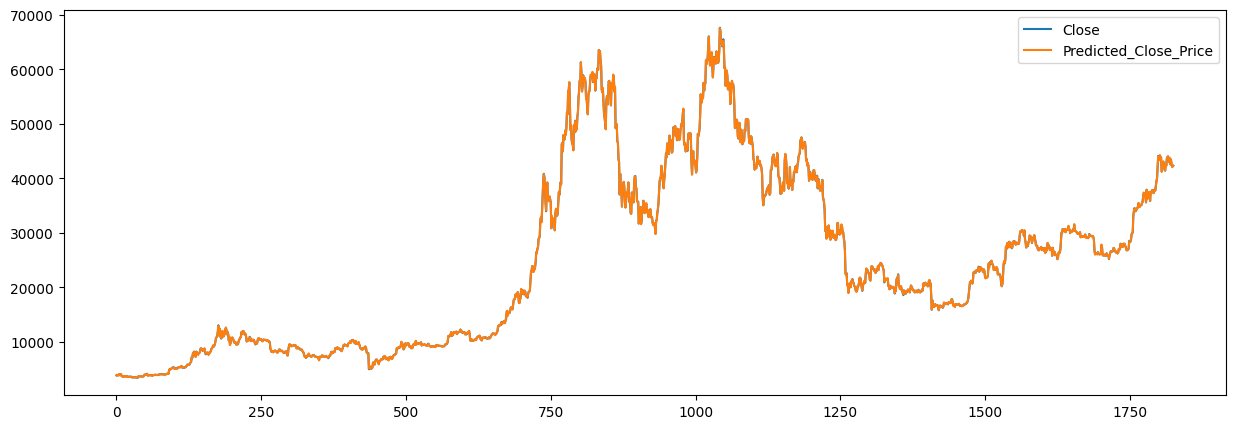

In [79]:
btc_train['Predicted_Close_Price'] = model.predict(X_train)
btc_train[['Close','Predicted_Close_Price']].plot(figsize=(15, 5))

In [80]:
btc_val['Forecast_XGBoost'] = model.predict(X_test)
overall_data = pd.concat([btc_train, btc_val], sort=False)

<Axes: >

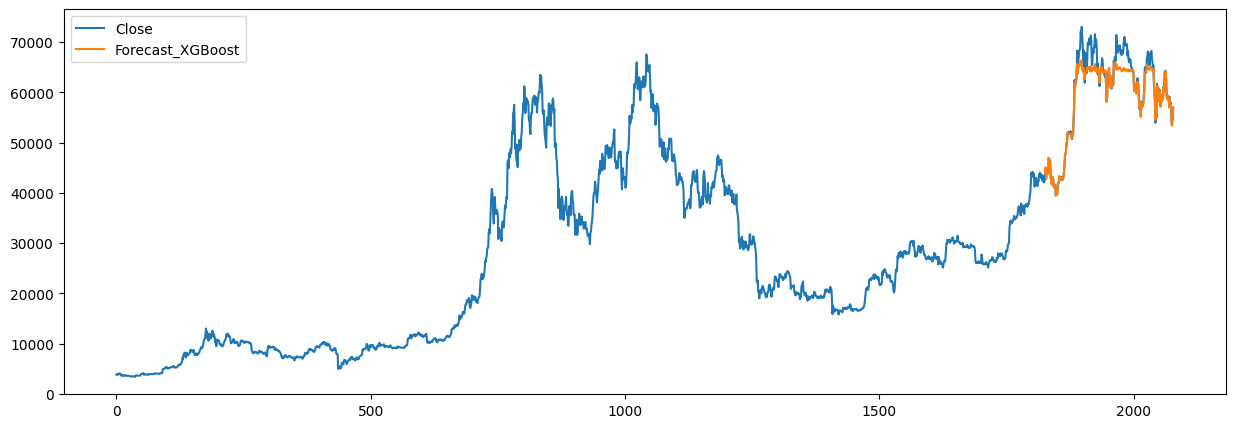

In [81]:
overall_data[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))

<Axes: >

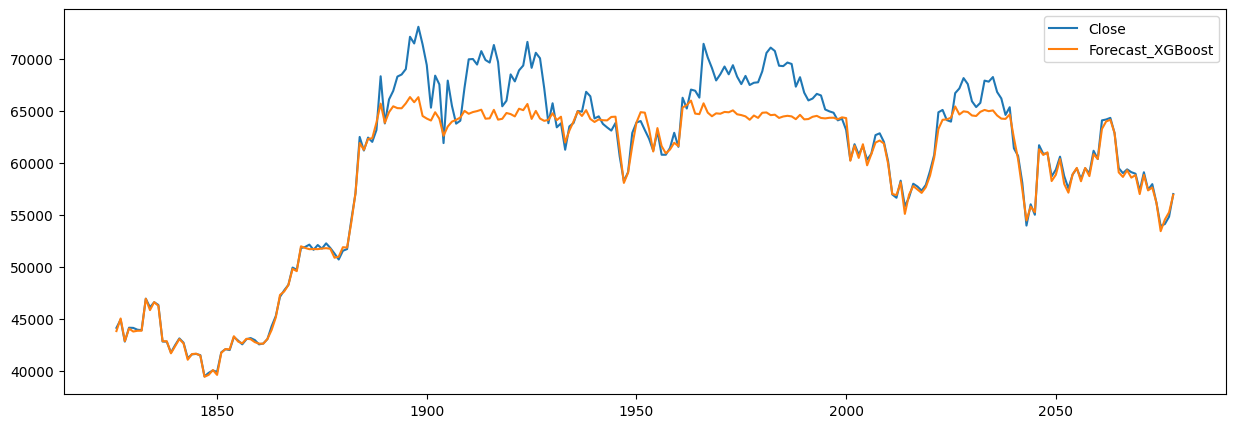

In [82]:
btc_val[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))

In [84]:
train_mae = mean_absolute_error(btc_train['Close'], btc_train['Predicted_Close_Price'])
train_rmse = np.sqrt(mean_squared_error(btc_train['Close'], btc_train['Predicted_Close_Price']))
train_r2 = r2_score(btc_train['Close'], btc_train['Predicted_Close_Price'])

print(f"Train MAE : {train_mae}")
print(f"Train RMSE : {train_rmse}")
print(f"Train R2 : {train_r2}")

Train MAE : 37.10117409446023
Train RMSE : 51.040650206677164
Train R2 : 0.9999898998928924


In [85]:
test_mae = mean_absolute_error(btc_val['Close'], btc_val['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(btc_val['Close'], btc_val['Forecast_XGBoost']))
test_r2 = r2_score(btc_val['Close'], btc_val['Forecast_XGBoost'])

print(f"Test MAE : {test_mae}")
print(f"Test RMSE : {test_rmse}")
print(f"Test R2 : {test_r2}")

Test MAE : 1384.7714457756917
Test RMSE : 2285.2847399053885
Test R2 : 0.9340291937794404


XGBoost model appears to forecast the dips in the data quite well, but does not capture the higher peaks